In [1]:
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

In [2]:
from reskan import *
import torch

In [3]:
#f = lambda input: 3 * torch.pow(torch.cosh(0.25 * (input[:, [1]]**2 - 2 * input[:, [0]])).reciprocal(), 2)
f = lambda input: 1.5 * torch.pow(torch.cosh(0.5 * input[:, [0]] - 0.25 *torch.sin(input[:, [1]])).reciprocal(), 2)
#f = lambda input: 3 * torch.pow(torch.cosh(0.125 * (input[:, [1]]**4 - 4 * input[:, [0]])).reciprocal(), 2)
#f = lambda input: 6 * torch.pow(torch.cosh(0.5 * (input[:, [0]] + (4 / 5) * torch.exp(-0.5 * input[:, [1]])) * (torch.cos(input[:, [1]]) - 2 * torch.sin(input[:, [1]]))).reciprocal(), 2)
#f = lambda input: 6 * torch.pow(torch.cosh(0.5 * (input[:, [0]] - 4 * torch.log(input[:, [1]]))).reciprocal(), 2)
#f = lambda input: 0.75 * torch.pow(torch.cosh(0.5 * input[:, [0]] - 0.5 * torch.exp(0.5 * input[:, [1]])).reciprocal(), 2)
#f = lambda input: -1.5 * torch.pow(torch.cosh(0.5 * input[:, [0]] + 0.375 * torch.pow(input[:, [1]], 2)).reciprocal(), 2)
#f = lambda input: 0.75 * torch.pow(torch.cosh(0.5 * input[:, [0]] - 0.25 * 4 * torch.log(torch.abs(input[:, [1]]))), 2).reciprocal()


x_range = [-4,4]
t_range = [-4,4]
x_steps = 200
t_steps = 200
points_r = 800
noise = 0.1
device = 'cuda' if torch.cuda.is_available() else 'cpu'

input_k, input_r, U, t = generate_data(f, x_range, t_range, x_steps, t_steps, points_r, noise, vc_plot=True, device=device)
print(input_k.shape)
print(input_r.shape)
print(U.shape)


torch.Size([40000, 2])
torch.Size([800, 2])
torch.Size([800, 1])


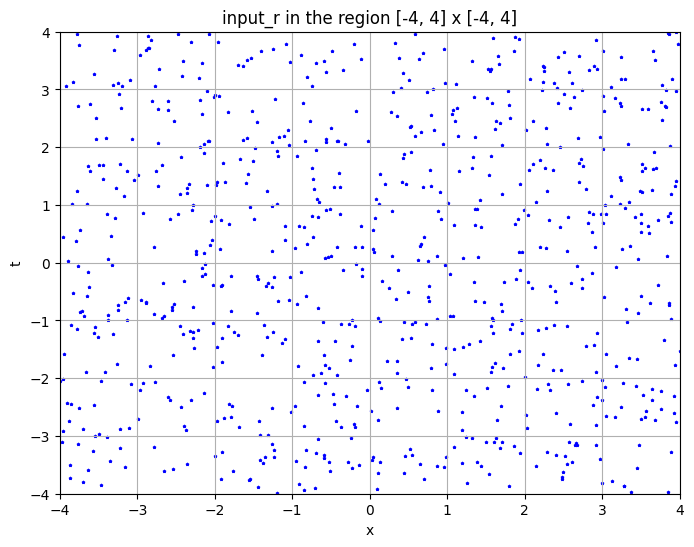

In [4]:
import matplotlib.pyplot as plt
points = input_r.cpu().detach().numpy()
plt.figure(figsize=(8, 6))
plt.scatter(points[:, 0], points[:, 1], s=3, c='blue', marker='*')
plt.title("input_r in the region [-4, 4] x [-4, 4]")
plt.xlabel("x")
plt.ylabel("t")
plt.xlim(x_range)
plt.ylim(t_range)
plt.grid(True)
plt.show()

In [5]:
rhs_des = [
    '',
 'u',
 'u^2',
 'u^3',
# 'u_{x}',
 'u^2u_{x}',
 'u^3u_{x}',
 'u_{xx}',
 'uu_{xx}',
 'u^2u_{xx}',
'u^3u_{xx}',
 'uu_{xxx}',
 'u^2u_{xxx}',
 'u^3u_{xxx}',
 'uu_{x}',
 'u_{xxx}'
 ]

In [6]:
Nd = 50  # 隐藏层节点数量
Nh = 2   # 每个残差块中网络层数
Nb = 3   # 残差块数量

model = VC_PIKAN(Nd=Nd, Nh=Nh, Nb=Nb, rhs_des=rhs_des, range_x=x_range, range_t=t_range, seed=6666, grid=5, base_fun='identity', device=device)
#model.load_state_dict(torch.load('KdV1_iter2.pt'))

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0


In [7]:
model.fit(input_r, input_k, U, steps=300, alpha=0.1, lam=0.001, lamb_l1=0.1, lamb_coef=1, lamb_coefdiff=0., lamb_entropy=2., normal=False, mode='all', save_fig=True, img_folder='./KdV1_iter1',save_loss=True, loss_filename='KdV1.txt')

  0%|          | 0/300 [00:00<?, ?it/s]

Training on cuda


100%|██████████| 300/300 [32:21<00:00,  6.47s/it, loss=-6.13, loss_data=0.00193, loss_pde=0.000372, loss_reg=2.03]


Original:
After pruning:
saving model version 0.4


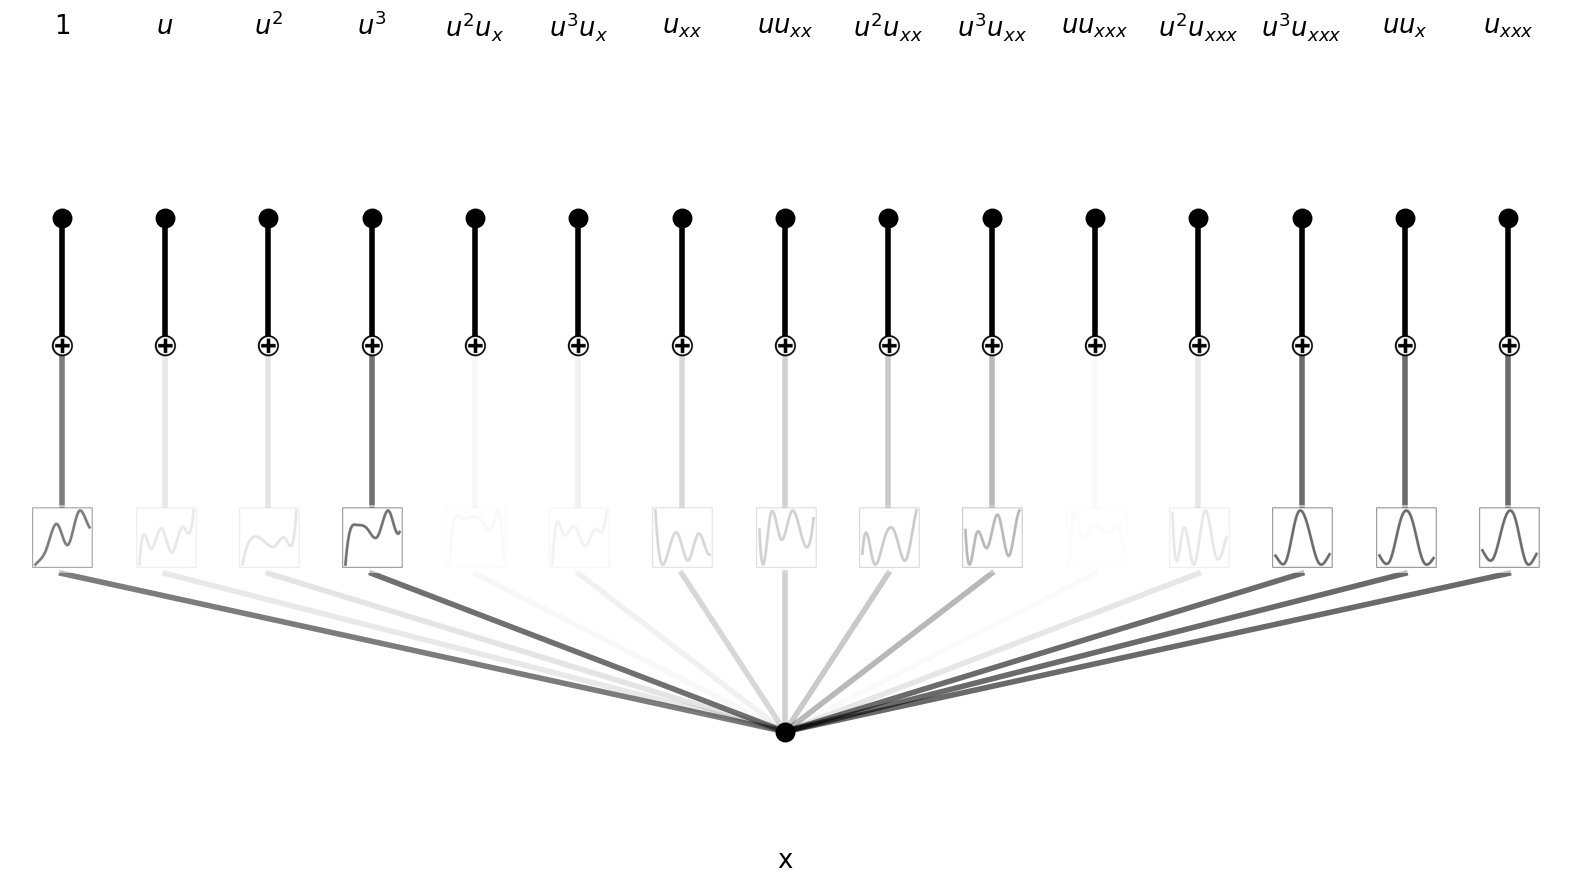

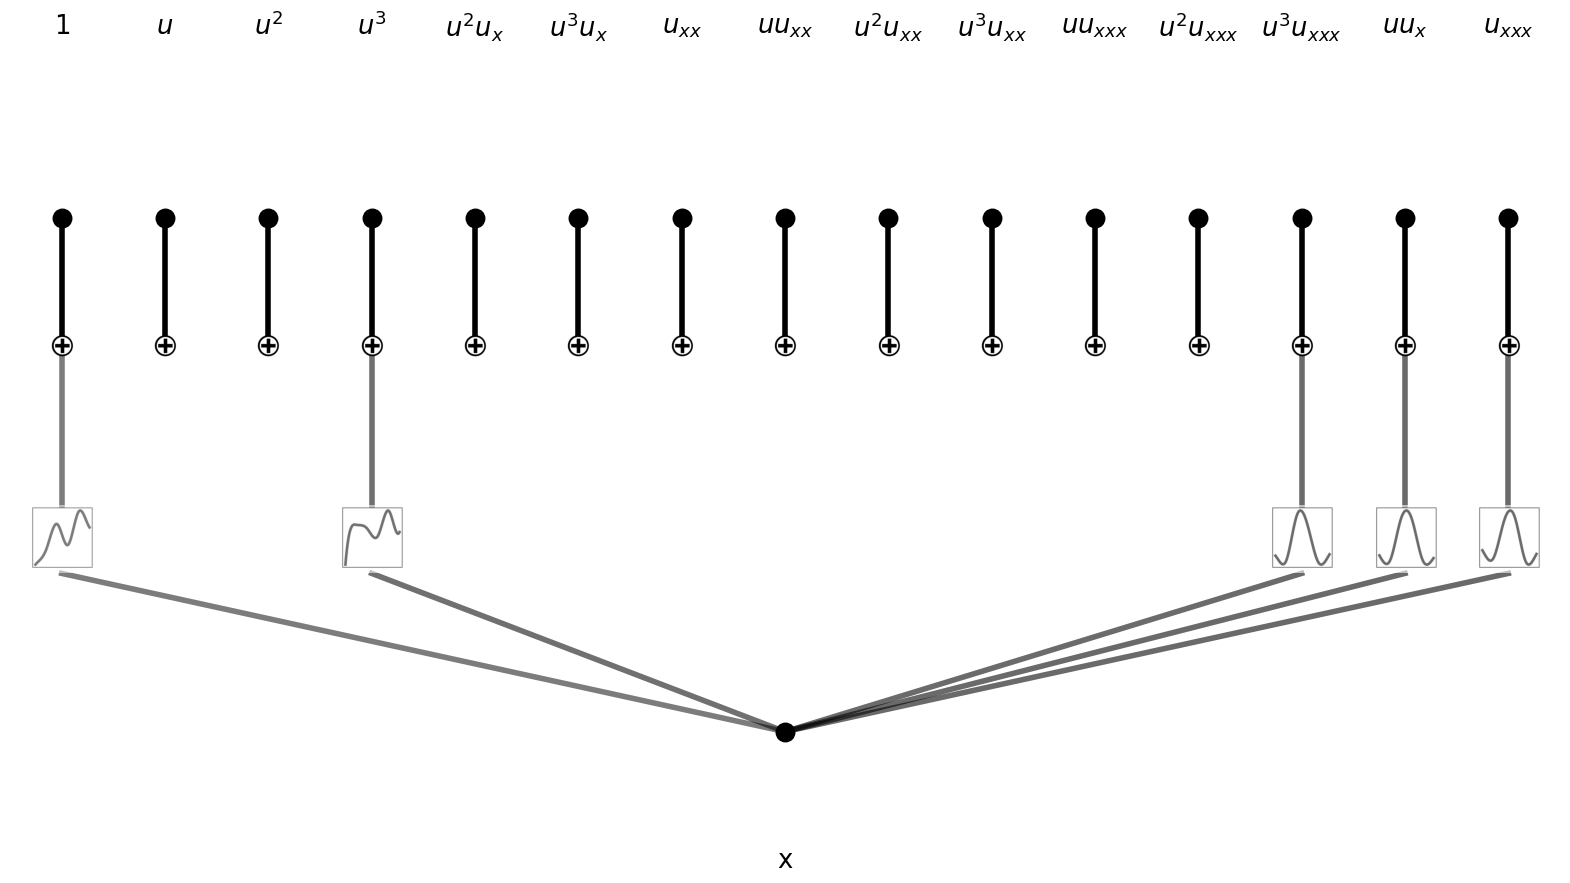

In [11]:
model.prune_kan(input_k)

saving model version 0.7


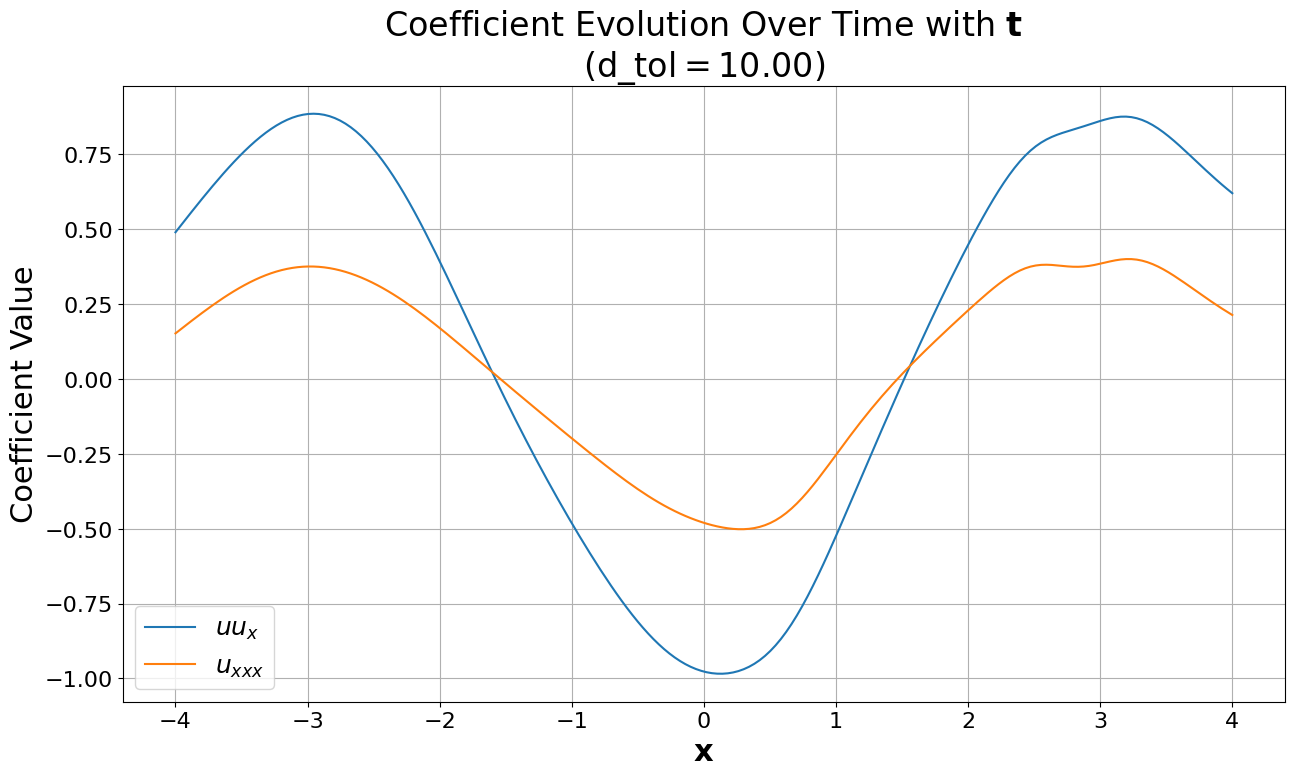

Plot saved as vc_plot/KdV1_iter1.pdf


In [14]:
lam = 1e-5
d_tol = 10
W =  model.G_STRidge(input_k, lam, d_tol, t_steps, x_steps)
model.ridge_plot(d_tol, t, filename="KdV1_iter1")

In [16]:
model.active_remove_edge(0)
model.active_remove_edge(3)
model.active_remove_edge(12)
model.fit(input_r, input_k, U, steps=100, alpha=1, lam=0., lamb_l1=0.1, lamb_coef=1, lamb_coefdiff=0., lamb_entropy=2., normal=False, mode='all', save_fig=True, img_folder='./KdV1_iter2',save_loss=True, loss_filename='KdV1.txt')

saving model version 0.11
saving model version 0.12
saving model version 0.13


  0%|          | 0/100 [00:00<?, ?it/s]

Training on cuda


100%|██████████| 100/100 [09:07<00:00,  5.48s/it, loss=-6.2, loss_data=0.002, loss_pde=2.16e-5, loss_reg=2.2]   


In [20]:
model.kan.fix_symbolic(0,0,13,'cos')
model.kan.fix_symbolic(0,0,14,'cos')

r2 is 0.9956699013710022
saving model version 0.15
r2 is 0.980443000793457
saving model version 0.16


-100000000.0

In [21]:
model.fit(input_r, input_k, U, steps=100, alpha=1, lam=0., lamb_l1=0.1, lamb_coef=1, lamb_coefdiff=0., lamb_entropy=2., normal=False, mode='all', save_fig=True, img_folder='./KdV1_symbolic',save_loss=True, loss_filename='KdV1.txt')

  0%|          | 0/100 [00:00<?, ?it/s]

Training on cuda


100%|██████████| 100/100 [09:16<00:00,  5.56s/it, loss=-6.21, loss_data=0.00198, loss_pde=2.66e-5, loss_reg=0.384]


In [23]:
model.kan.symbolic_formula()

([-4.68427497253288e-5,
  -0.0905888229608536,
  0.0726031139492989,
  0.0101781086996198,
  0.0996620208024979,
  0.154006332159042,
  0.137362465262413,
  -0.0177406147122383,
  -0.0442348942160606,
  0.0153720192611217,
  0.0968245267868042,
  0.0788728445768356,
  -0.0113891558721662,
  -1.01209032535553*cos(1.0230633020401*x_1 - 9.41188621520996) - 0.0493082068860531,
  0.0418262705206871 - 0.507254540920258*cos(1.04015707969666*x_1 - 9.40548229217529)],
 [x_1])

In [3]:
#f = lambda input: 3 * torch.pow(torch.cosh(0.25 * (input[:, [1]]**2 - 2 * input[:, [0]])).reciprocal(), 2)
#f = lambda input: 1.5 * torch.pow(torch.cosh(0.5 * input[:, [0]] - 0.25 *torch.sin(input[:, [1]])).reciprocal(), 2)
#f = lambda input: 3 * torch.pow(torch.cosh(0.125 * (input[:, [1]]**4 - 4 * input[:, [0]])).reciprocal(), 2)
#f = lambda input: 6 * torch.pow(torch.cosh(0.5 * (input[:, [0]] + (4 / 5) * torch.exp(-0.5 * input[:, [1]])) * (torch.cos(input[:, [1]]) - 2 * torch.sin(input[:, [1]]))).reciprocal(), 2)
#f = lambda input: 6 * torch.pow(torch.cosh(0.5 * (input[:, [0]] - 4 * torch.log(input[:, [1]]))).reciprocal(), 2)
#f = lambda input: 0.75 * torch.pow(torch.cosh(0.5 * input[:, [0]] - 0.5 * torch.exp(0.5 * input[:, [1]])).reciprocal(), 2)
#f = lambda input: -1.5 * torch.pow(torch.cosh(0.5 * input[:, [0]] + 0.375 * torch.pow(input[:, [1]], 2)).reciprocal(), 2)
f = lambda input: 0.75 * torch.pow(torch.cosh(0.5 * input[:, [0]] - 0.25 * 4 * torch.log(torch.abs(input[:, [1]]))), 2).reciprocal()


x_range = [-4,4]
t_range = [1,5]
x_steps = 200
t_steps = 200
points_r = 800
noise = 0.1
device = 'cuda' if torch.cuda.is_available() else 'cpu'

input_k, input_r, U, t = generate_data(f, x_range, t_range, x_steps, t_steps, points_r, noise, vc_plot=True, device=device)
print(input_k.shape)
print(input_r.shape)
print(U.shape)


torch.Size([40000, 2])
torch.Size([800, 2])
torch.Size([800, 1])


In [4]:
rhs_des = [
    '',
 'u',
 'u^2',
 'u^3',
# 'u_{x}',
 'u^2u_{x}',
 'u^3u_{x}',
 'u_{xx}',
 'uu_{xx}',
 'u^2u_{xx}',
'u^3u_{xx}',
 'uu_{xxx}',
 'u^2u_{xxx}',
 'u^3u_{xxx}',
 'uu_{x}',
 'u_{xxx}'
 ]

In [5]:
Nd = 50  
Nh = 2   
Nb = 3   # 残差块数量

model = VC_PIKAN(Nd=Nd, Nh=Nh, Nb=Nb, rhs_des=rhs_des, range_x=x_range, range_t=t_range, seed=6666, grid=5, base_fun='identity', device=device)
model.fit(input_r, input_k, U, steps=300, alpha=0.1, lam=0.001, lamb_l1=0.1, lamb_coef=1, lamb_coefdiff=0., lamb_entropy=2., normal=False, mode='all', save_fig=True, img_folder='./KdV2_iter1',save_loss=True, loss_filename='KdV2.txt')


checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0


  0%|          | 0/300 [00:00<?, ?it/s]

Training on cuda


100%|██████████| 300/300 [31:34<00:00,  6.31s/it, loss=-7.06, loss_data=0.000678, loss_pde=0.000138, loss_reg=1.64]


Original:
After pruning:
saving model version 0.1


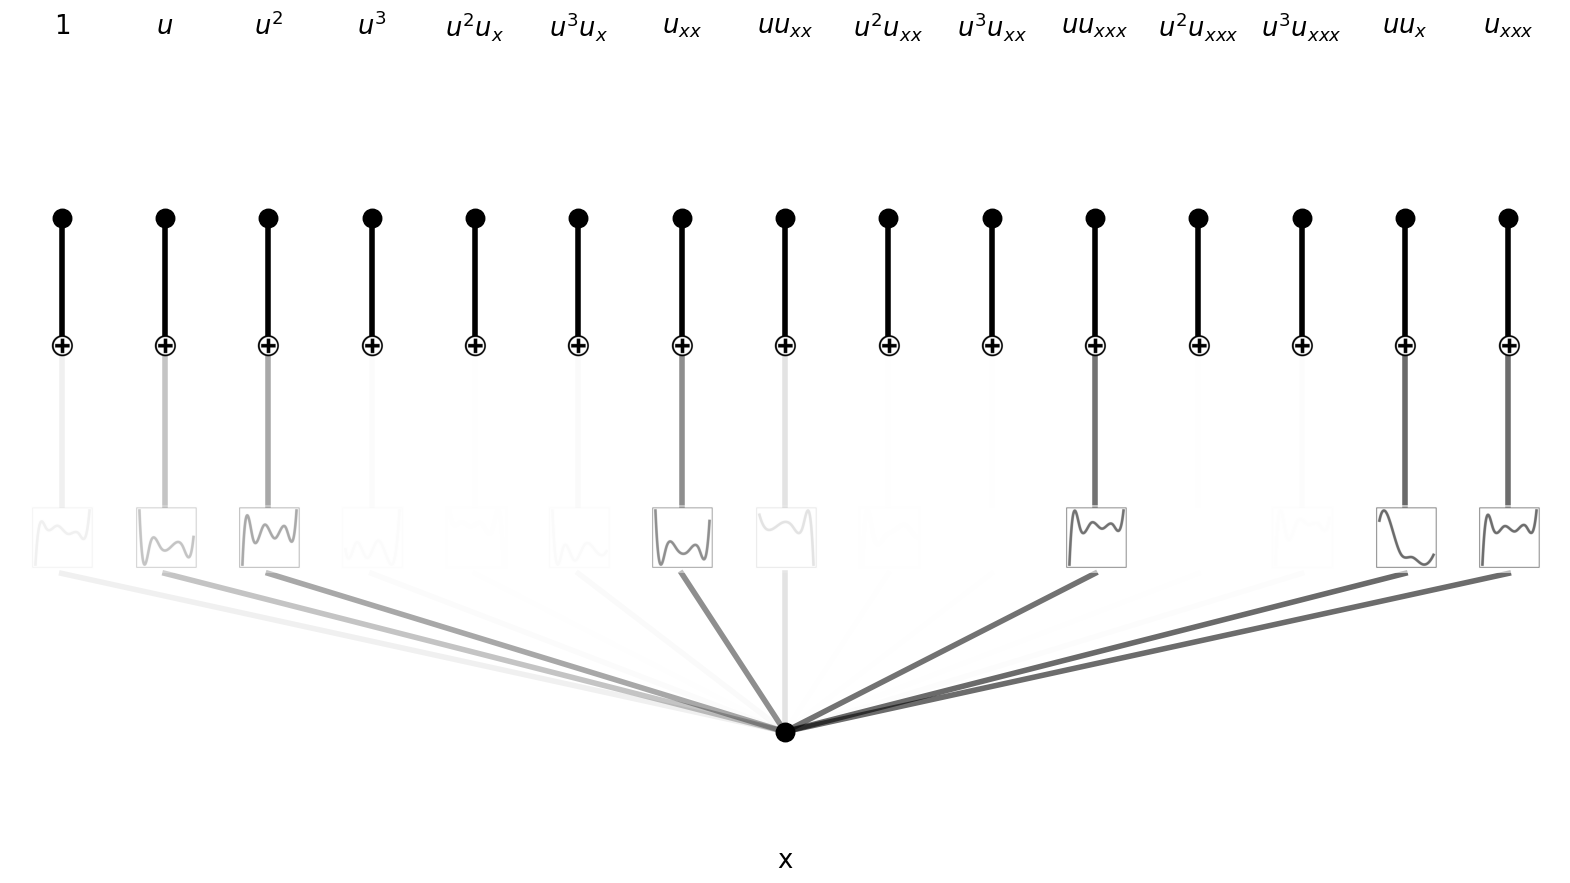

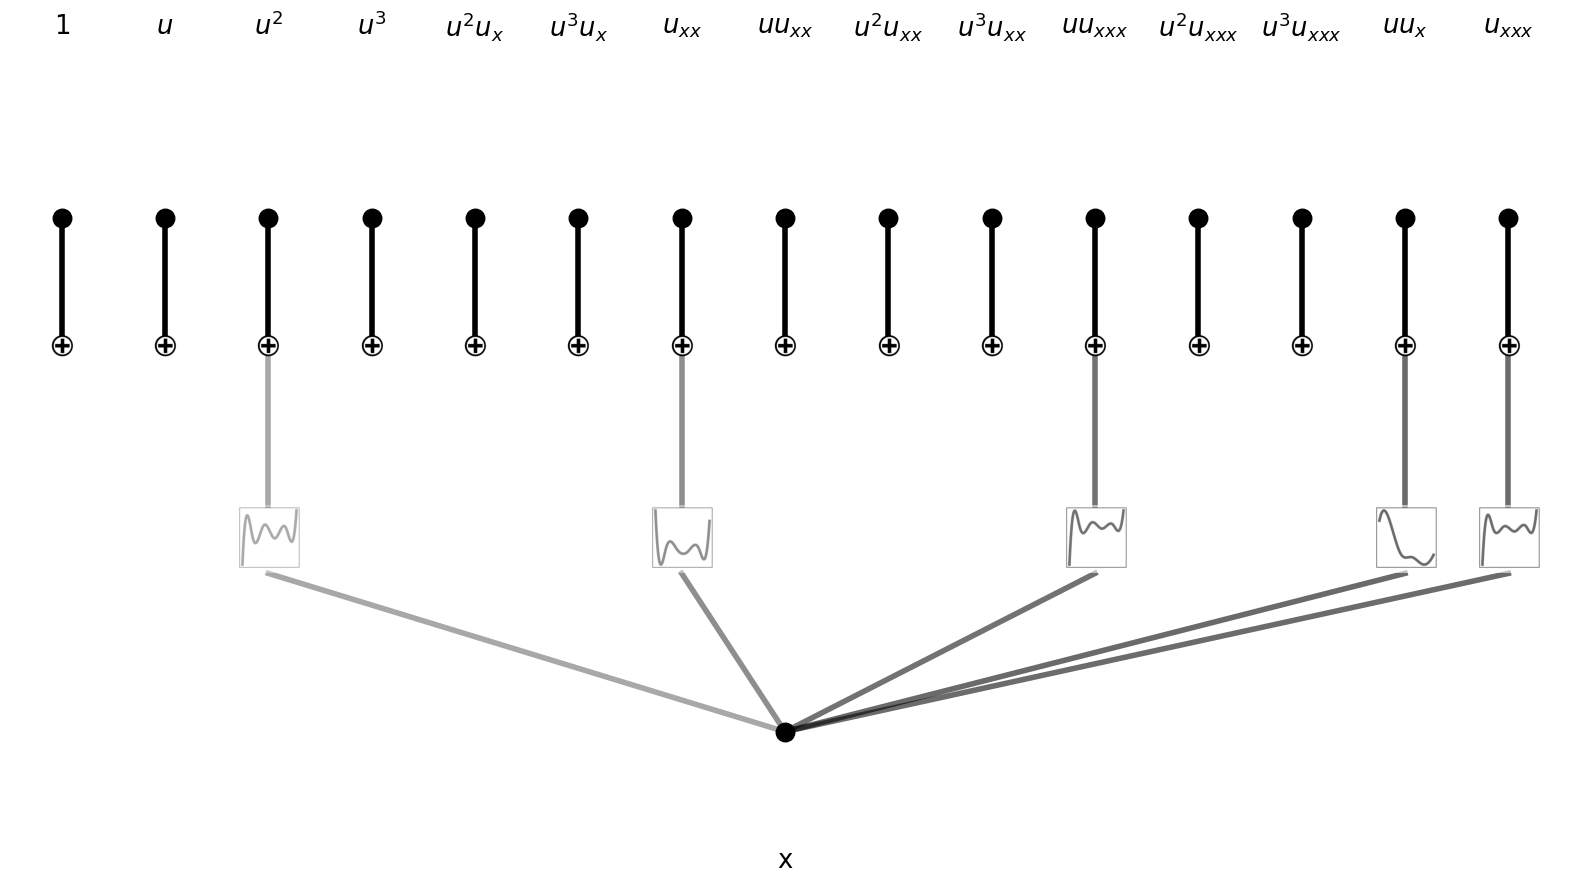

In [6]:
model.prune_kan(input_k)

saving model version 0.2


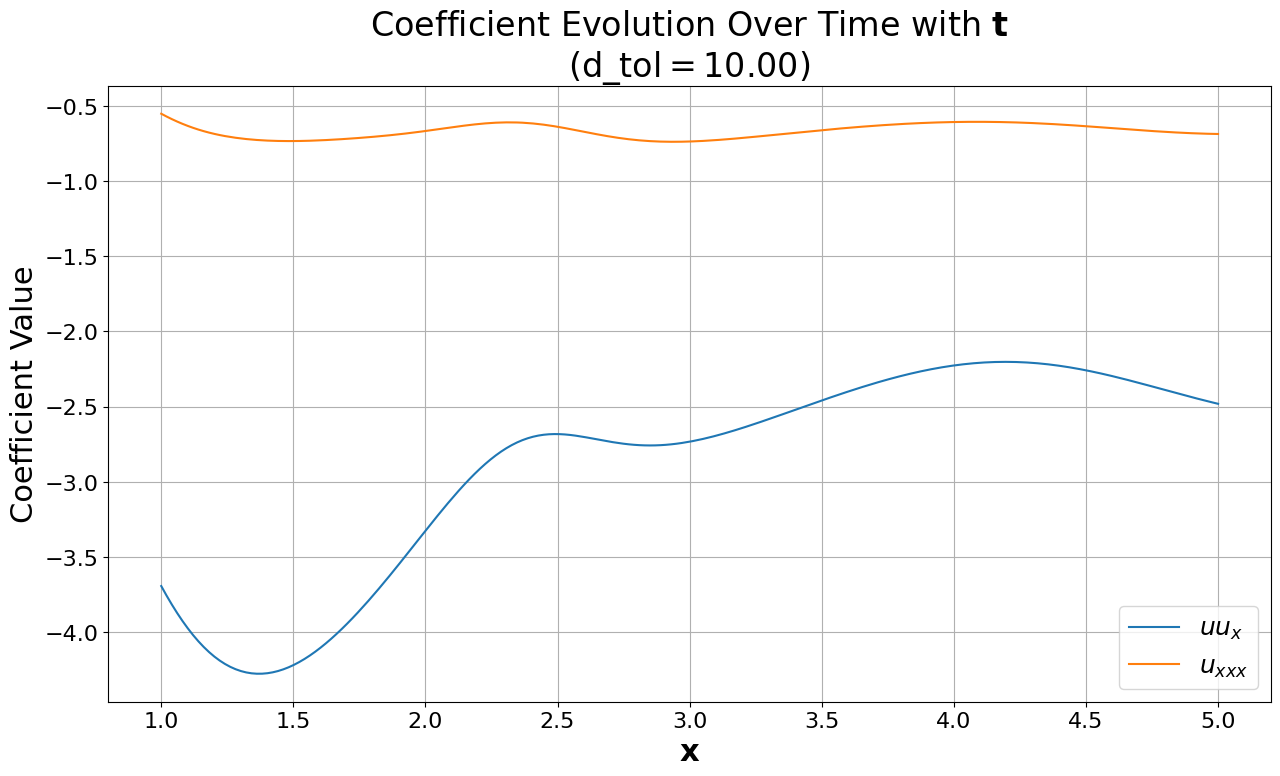

Plot saved as vc_plot/KdV2_iter1.pdf


In [7]:
lam = 1e-5
d_tol = 10
W =  model.G_STRidge(input_k, lam, d_tol, t_steps, x_steps)
model.ridge_plot(d_tol, t, filename="KdV2_iter1")

In [8]:
model.active_remove_edge(2)
model.active_remove_edge(6)
model.active_remove_edge(10)
model.fit(input_r, input_k, U, steps=100, alpha=1, lam=0.0, lamb_l1=0.1, lamb_coef=1, lamb_coefdiff=0., lamb_entropy=2., normal=False, mode='all', save_fig=True, img_folder='./KdV2_iter2',save_loss=True, loss_filename='KdV2.txt')

saving model version 0.3
saving model version 0.4
saving model version 0.5


  0%|          | 0/100 [00:00<?, ?it/s]

Training on cuda


100%|██████████| 100/100 [08:45<00:00,  5.25s/it, loss=-7.3, loss_data=0.000673, loss_pde=4.34e-6, loss_reg=2.29]


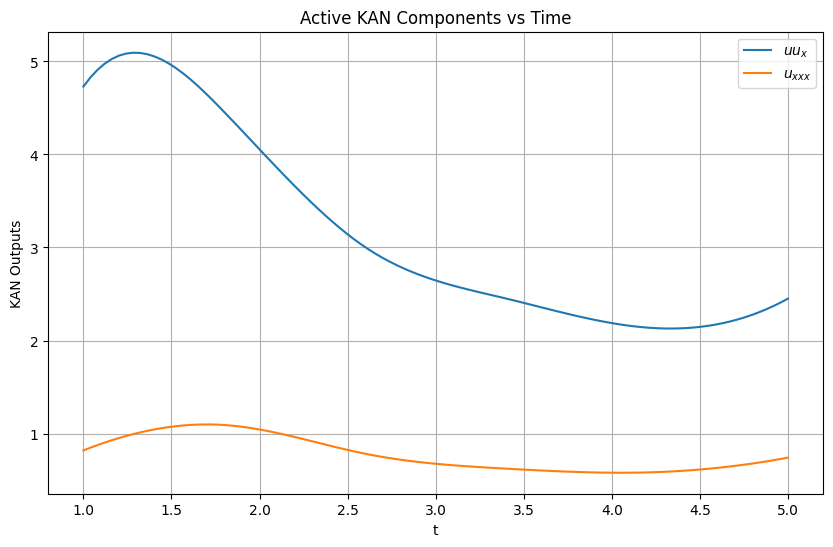

In [10]:
model.plot_kan_components()

In [11]:
model.kan.fix_symbolic(0,0,13,'1/x')
model.kan.fix_symbolic(0,0,14,'1/x')

r2 is 0.9387475252151489
saving model version 0.7
r2 is 0.7136287689208984
r2 is not very high, please double check if you are choosing the correct symbolic function.
saving model version 0.8


tensor(0.7136, device='cuda:0')

In [12]:
model.fit(input_r, input_k, U, steps=100, alpha=1, lam=0.0, lamb_l1=0.1, lamb_coef=1, lamb_coefdiff=0., lamb_entropy=2., normal=False, mode='all', save_fig=True, img_folder='./KdV2_symbolic',save_loss=True, loss_filename='KdV2.txt')

  0%|          | 0/100 [00:00<?, ?it/s]

Training on cuda


100%|██████████| 100/100 [09:04<00:00,  5.45s/it, loss=-7.3, loss_data=0.000674, loss_pde=4.38e-6, loss_reg=0.469]


In [13]:
model.kan.symbolic_formula()

([0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  -0.372867316007614 - 13.2560977935791/(-1.07900166511536*x_1 - 0.96693617105484),
  -0.364738792181015 - 1.38567757606506/(-0.192222565412521*x_1 - 0.69823545217514)],
 [x_1])